In [1]:
import numpy as np
from fourier import compute_fourier_coeff
from signal_functions import truncated_sine_series, truncated_fourier_series
from kernels import complex_exponential_kernel, cosine_kernel
from inference_utils import  run_inference_error, run_inference_prediction
from plotting import plot_error_with_std, plot_true_vs_approximation

In [2]:
#set random seed for reproducibility
seed = 42

num_samples = 14   # number of samples
num_experiments = 10 # number of experiments when computing the error


#time grid 
grid_size = 2**12 # number of grid points

t_left = -.5
t_right = .5

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)


In [3]:
input_signals = 'time-loc'  # 'time-loc' or 'freq-loc'

In [4]:
#parameter for target signal
target_decay_rate = 1.1 # decay rate of the target signal

# parameter for kernel
kernel_decay_rate =  1.01 # decay rate of the kernel

if kernel_decay_rate <=1 or target_decay_rate<=1:
    raise ValueError("kernel_decay_rate and target_decay_rate must be > 1")


# time-loc signals
loc_parameter = 0.076 

if input_signals == 'time-loc':
    alpha_sup = (2*target_decay_rate -1 - kernel_decay_rate) / 2*kernel_decay_rate
    

# freq-loc signals 

freq_loc_inputs_decay = .1  

if input_signals == 'freq-loc':
    alpha_sup = (2*target_decay_rate -1 - kernel_decay_rate) / 2*(kernel_decay_rate + freq_loc_inputs_decay)


print("alpha_sup" , alpha_sup)

alpha_sup 0.09595000000000009


In [5]:
alpha = .9 * alpha_sup

lam_val = 1e-4, '1e-4'

noise = .02

In [6]:
# Ground truth function and observation  noise         
# y_i = x_i * target + noise, where x_i is the input signal

sum_terms_target = 30  # index  of truncation of the fourier series
target = truncated_sine_series(
    input_points=time_array, decay_rate=target_decay_rate, num_terms=sum_terms_target
)

##fourier coefficients of w_true
target_fourier_coeff = compute_fourier_coeff(
    target, time_span
)  # normalized by the number of grid points


# for freq-loc inputs
max_sum_freq_signals = sum_terms_target

In [7]:
sum_terms_kernel = sum_terms_target

evaluated_kernel = cosine_kernel(time_array, kernel_decay_rate, sum_terms_kernel)

kernel_coeff = compute_fourier_coeff(evaluated_kernel, time_span)
kernel_coeff = np.abs(kernel_coeff)   ## CHECK WHY YOU NEED THIS

In [8]:
#freq-loc
max_value = sum_terms_kernel + 10

In [9]:
# run inference for time-localized signals
error_sampmean, error_sampstd, error_logmea, error_logstd = run_inference_error(
    signal_loc_type=input_signals,
    num_samples=num_samples,
    num_experiments=num_experiments,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff= kernel_coeff,
    target_fourier_coeff=target_fourier_coeff,
    noise=noise,
    time_grid_points=grid_size,
    alpha=alpha,
    series_truncation=sum_terms_kernel,
    loc_parameter=loc_parameter  # Time-localized parameter
)


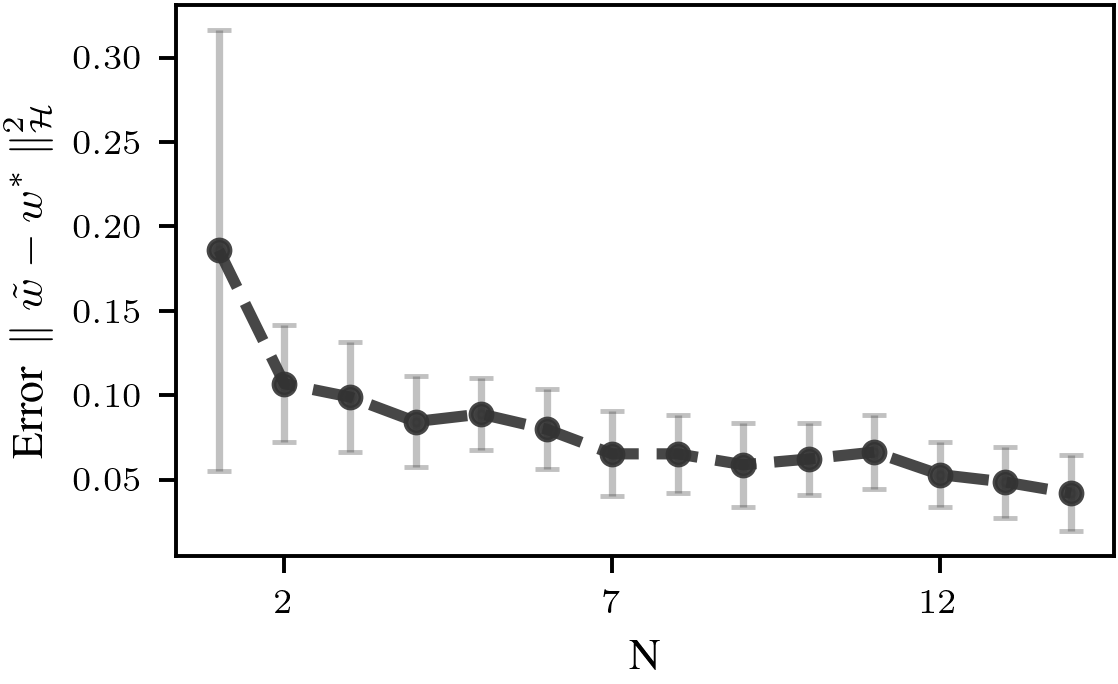

In [10]:
plot_error_with_std(num_samples, error_sampmean, error_sampstd)

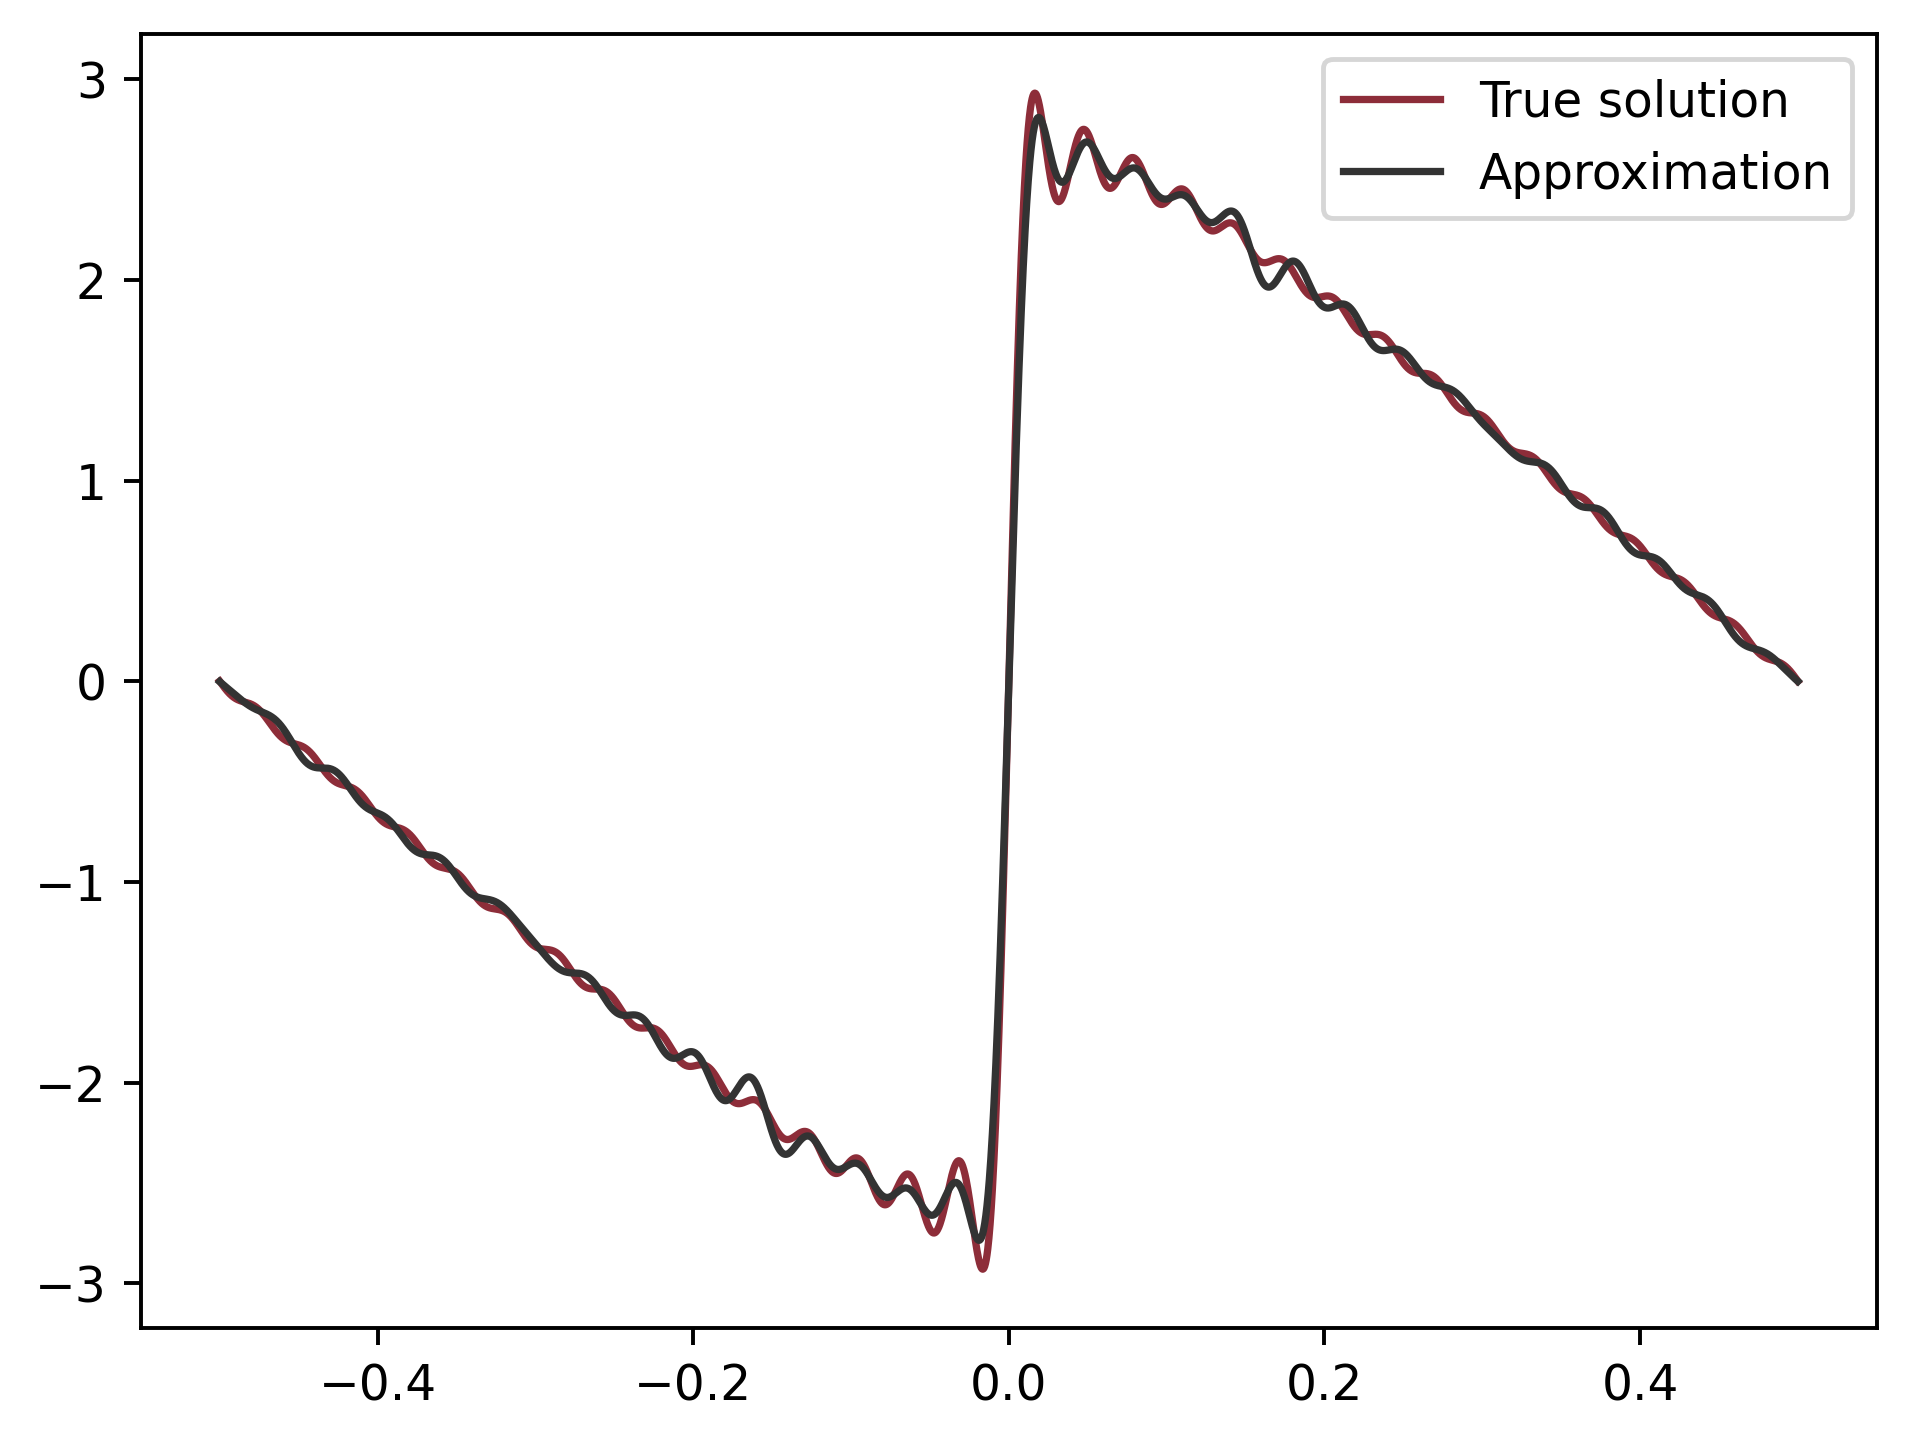

In [11]:
prediction = run_inference_prediction(
    signal_loc_type=input_signals,
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_fourier_coeff=target_fourier_coeff,
    noise=noise,
    time_grid_points=grid_size,
    alpha=alpha,
    series_truncation=sum_terms_kernel,
    loc_parameter=loc_parameter
)
plot_true_vs_approximation(time_array, target, prediction)
#something not right: you should see the difference in prediction between 2 and 15 samples!!!!

In [12]:
# #Inference and compute H errors
# for n in range(1,num_samples+1):
    
#     error_of_exper = np.zeros(num_experiments)
    
#     for j in range(0,num_experiments):
    

#         #Localized in frequency
#         #random vector for frequencies
#         # L = power_law_samples(n, L_max, eta)

#         # X = generate_frequency_localized_samples(n, time_array, max_value, exponent=eta, power_law_func=power_law_samples, seed=seed)

        
#          #Localized in time
#         R = np.random.normal(0,.25,n)

#         X = generate_time_localized_samples(n, time_array, delta)
   
#         # fourier coefficients of X, Y and true sol  
#         X_fourier =  compute_fourier_coeff(X,time_span)                                    #np.fft.fft(X, axis=0)  / d 

#         #take the conjugate of the fourier coefficients of X
#         X_fourier_conj = np.conj(X_fourier) 
        
#         Y = compute_output_data_matrix(X_fourier , target_f_coeff, noise,time_grid_points)

#         Y_fourier = compute_fourier_coeff(Y,time_span)                                    

#         lamb =  1e-4 * n ** (-  1  / (2* alpha + 2))
#         w_fourier = np.zeros(time_array.size, dtype=np.complex128)
#         for l in range(time_array.size):
#             eigenval = kernel_coeff[l] * (np.abs(X_fourier[l,:])**2).sum() / num_samples
#             term1 = kernel_coeff[l] / (eigenval + lamb)
#             term2 = (X_fourier_conj[l,:] * Y_fourier[l,:]).sum() / num_samples

#             w_fourier[l] = term1 * term2

#         w_diff_coeff = w_fourier - target_f_coeff
#         error_h_squared = (np.abs(w_diff_coeff[:M])**2 / kernel_coeff[:M]).sum()

#         error_of_exper[j] = error_h_squared 
    
#     error_sampmean[n-1] = np.mean(error_of_exper)     #error_of_exp.sum() / num_exp
#     error_sampstd[n-1] = np.std(error_of_exper)        #np.sqrt((np.square(error_of_exp - error_sampmean[n-1] )).sum() / (num_exp-1))
#     error_logmea[n-1] = np.mean(np.log(error_of_exper))
#     error_logstd[n-1] = np.std(np.log(error_of_exper))